# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import seaborn as sns
import shap
import xgboost as xgb
import lightgbm as lgb

# Importing Preproccessed Data

In [2]:
file_path = "../../data/processed/train_data.csv"
df = pd.read_csv(file_path)
X=df.drop('target',axis=1)
y=df['target']
df2=pd.read_csv('../../data/processed/test_data.csv')
X_test=df2.drop('target',axis=1)
y_test=df2['target']

# filtering the features with Pearson Correlation

In [3]:
#calculate the correlation between features 

def pearson_correlation(X,y):
#calculate the mean 
    mean_X=sum(X)/len(X)
    mean_y=sum(y)/len(y)
    #calculate the covariance
    covariance=sum([(X[i]-mean_X)*(y[i]-mean_y) for i in range(len(X))])
    #calculate the standard deviation
    std_X=sum([(X[i]-mean_X)**2 for i in range(len(X))])**0.5
    std_y=sum([(y[i]-mean_y)**2 for i in range(len(y))])**0.5
    if std_X==0 or std_y==0:
        return 0
    #calculate the correlation
    correlation=covariance/(std_X*std_y)
    return correlation

In [4]:
def filter_by_pearson(data, threshold, threshold2):
    columns = data.columns 
    target = data['target']  
    #Filter columns that are too strongly correlated with the target
    columns_to_keep = set(columns)
    for column in columns:
        if column != 'target': 
            correlation_matrix = pearson_correlation(data[column], target) 
            # If the correlation is too strong, add the column to the list to remove
            if abs(correlation_matrix) <= threshold: 
                columns_to_keep.discard(column)


    #Compare columns with each other and remove the less correlated one with the target
    filtered_columns = list(columns_to_keep) 

    for i, column in enumerate(filtered_columns):
        for j in range(i + 1, len(filtered_columns)):  
            column2 = filtered_columns[j]

            # Calculate the correlation between the two columns
            correlation_matrix2 = pearson_correlation(data[column], data[column2])
            if  abs(correlation_matrix2) > threshold2: 
                # Calculate the correlation of both columns with the target
                correlation_matrix3 = pearson_correlation(data[column], target)
                correlation_matrix4 = pearson_correlation(data[column2], target)

                # Compare which column is more correlated with the target and keep it
                if abs(correlation_matrix3) > abs(correlation_matrix4):
                    columns_to_keep.discard(column2)
                else:
                    columns_to_keep.discard(column)

    indices_to_keep = [data.columns.get_loc(col) for col in columns_to_keep if col != 'target']
    return indices_to_keep

In [5]:
indices_after_filter=filter_by_pearson(df,0.3,0.7)
indices_after_filter

[752, 135, 125, 2, 25, 743, 404, 427, 744, 58]

# Visualisation of features before and after filtering

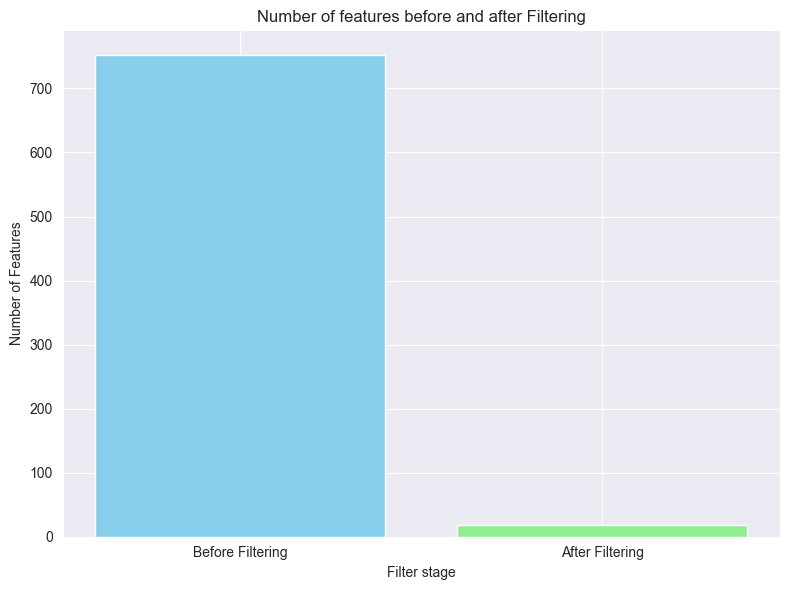

In [6]:
X = df.drop(columns=['target'])
plt.figure(figsize=(8,6))
plt.title("Number of features before and after Filtering")
plt.bar(['Before Filtering','After Filtering'],[len(X.columns),len(filter_by_pearson(df,0.3,0.8))],color=['skyblue', 'lightgreen'])
plt.xlabel("Filter stage")
plt.ylabel("Number of Features")
plt.tight_layout()
plt.show()

# Embedded methode with XGBoost for feature selection

In [7]:
xgb_model = xgb.XGBClassifier(random_state=42,n_estimators=500,learning_rate=0.1,objective='binary:logistic',eval_metric='logloss') # 0.85
xgb_model.fit(X,y)
# Get most importante features 
feature_importances =xgb_model.feature_importances_
threshold = 0.01
indices_afer_embeded = np.where(feature_importances > threshold)[0]
print(f"Number of features selected using Embeded Method : {len(indices_afer_embeded)}")
print(f"Indexes of features selected using Embeded Method : {indices_afer_embeded}")

# Calc Accuracy
preds = xgb_model.predict(X_test)
print(f"accuracy score : {accuracy_score(y_test,preds)}")

Number of features selected using Embeded Method : 20
Indexes of features selected using Embeded Method : [ 11  71 116 125 132 314 372 375 377 411 417 424 425 440 441 475 530 557
 570 681]
accuracy score : 0.950354609929078


# Visualisation of the number of features before and after the embedding method

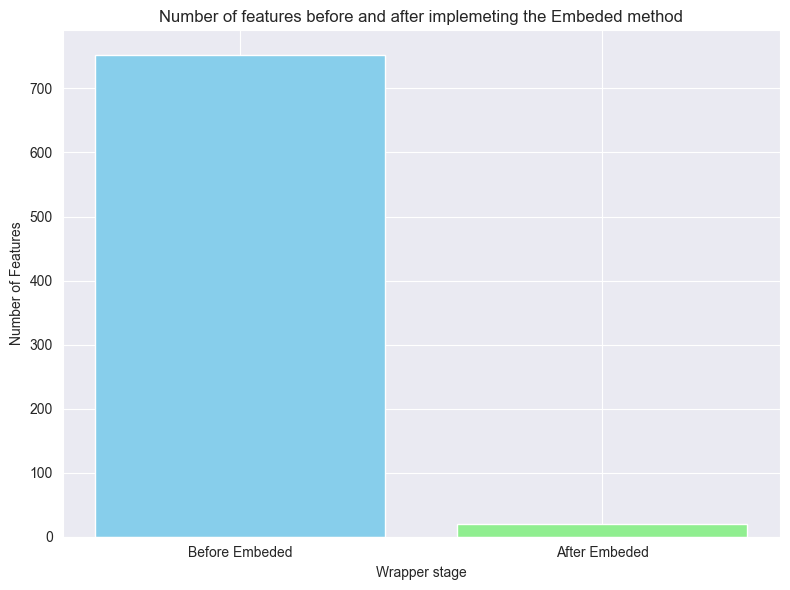

In [8]:
plt.figure(figsize=(8,6))
plt.title("Number of features before and after implemeting the Embeded method")
plt.bar(['Before Embeded','After Embeded'],[len(X.columns),len(indices_afer_embeded)],color=['skyblue', 'lightgreen'])
plt.xlabel("Wrapper stage")
plt.ylabel("Number of Features")
plt.tight_layout()
plt.show()

## Feature Selection Using Shap Values

# Train an initial LightGBM model


In [9]:
lgbm_model = lgb.LGBMClassifier(objective="binary", random_state=42)
lgbm_model.fit(X, y)

[LightGBM] [Info] Number of positive: 416, number of negative: 430
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 191280
[LightGBM] [Info] Number of data points in the train set: 846, number of used features: 753
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.491726 -> initscore=-0.033100
[LightGBM] [Info] Start training from score -0.033100
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


LGBMClassifier(objective='binary', random_state=42)

# Compute SHAP values


In [10]:
explainer = shap.TreeExplainer(lgbm_model)
shap_values = explainer.shap_values(X)

C:\Users\unknow\Desktop\IASD S1\Parkinson_disease_classification\venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


# Compute the mean absolute SHAP values for each feature

In [11]:
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

mnabsshapval = np.mean(mean_abs_shap_values)


# Calculate mean absolute SHAP values

In [12]:
shap_importance_df = pd.DataFrame({
    "Feature": X.columns,
    "Mean Absolute SHAP Value": mean_abs_shap_values
}).sort_values(by="Mean Absolute SHAP Value", ascending=False)


print("Top Features by SHAP Importance:\n", shap_importance_df)

Top Features by SHAP Importance:
                         Feature  Mean Absolute SHAP Value
125  std_delta_delta_log_energy                  1.067681
132         std_6th_delta_delta                  0.867667
440       tqwt_TKEO_mean_dec_12                  0.460968
425     tqwt_entropy_log_dec_33                  0.375910
62           mean_MFCC_6th_coef                  0.299029
..                          ...                       ...
226         app_TKEO_std_7_coef                  0.000000
225         app_TKEO_std_6_coef                  0.000000
224         app_TKEO_std_5_coef                  0.000000
223         app_TKEO_std_4_coef                  0.000000
222         app_TKEO_std_3_coef                  0.000000

[753 rows x 2 columns]


# Plot the distribution of mean absolute SHAP values

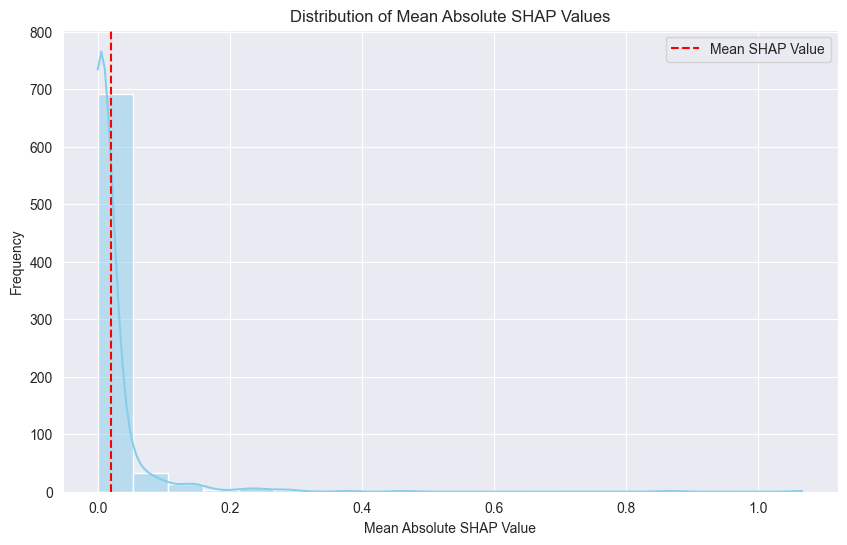

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(mean_abs_shap_values, bins=20, kde=True, color="skyblue")
plt.axvline(x=mnabsshapval, color="red", linestyle="--", label="Mean SHAP Value")
plt.title("Distribution of Mean Absolute SHAP Values")
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Plot SHAP summary

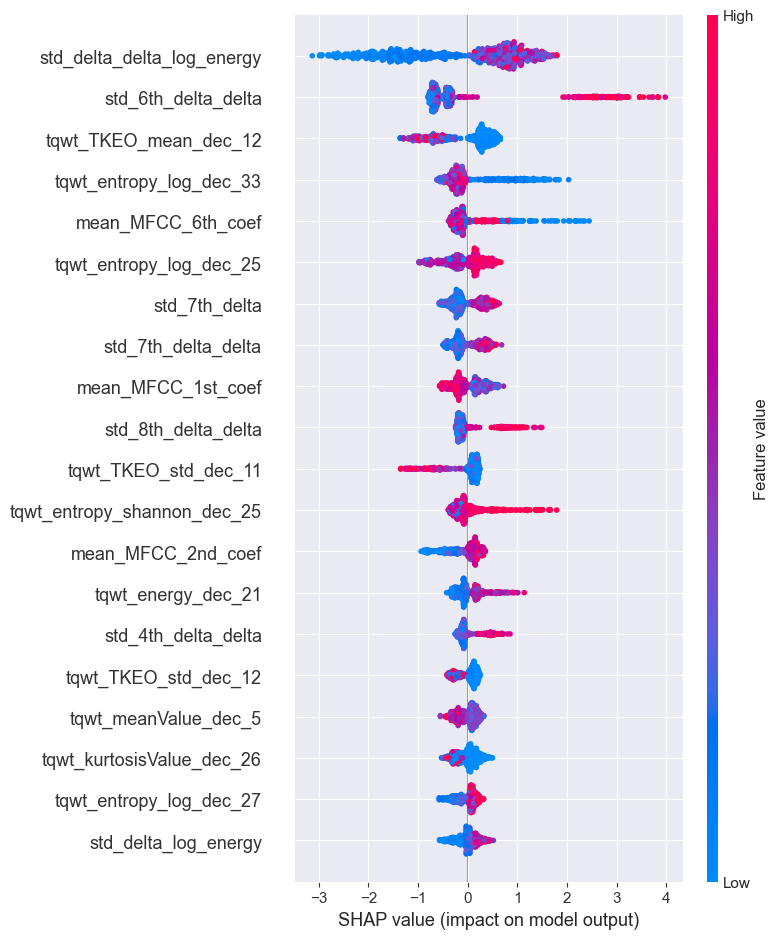

In [14]:
shap.summary_plot(shap_values, X, feature_names=X.columns)

# Drop features with SHAP values less than the mean

In [15]:
features_to_keep = shap_importance_df[shap_importance_df["Mean Absolute SHAP Value"] > mnabsshapval]["Feature"]
X_train_reduced1 = X[features_to_keep]
X_test_reduced1 = X_test[features_to_keep]


# Recalculate SHAP importance after the first reduction

In [16]:
shap_importance_df_reduced = shap_importance_df[shap_importance_df["Feature"].isin(features_to_keep)].reset_index(drop=True)

# Compute cumulative contribution

In [17]:
shap_importance_df_reduced["Cumulative Contribution"] = shap_importance_df_reduced[
    "Mean Absolute SHAP Value"
].cumsum() / shap_importance_df_reduced["Mean Absolute SHAP Value"].sum()

# Plot cumulative contribution

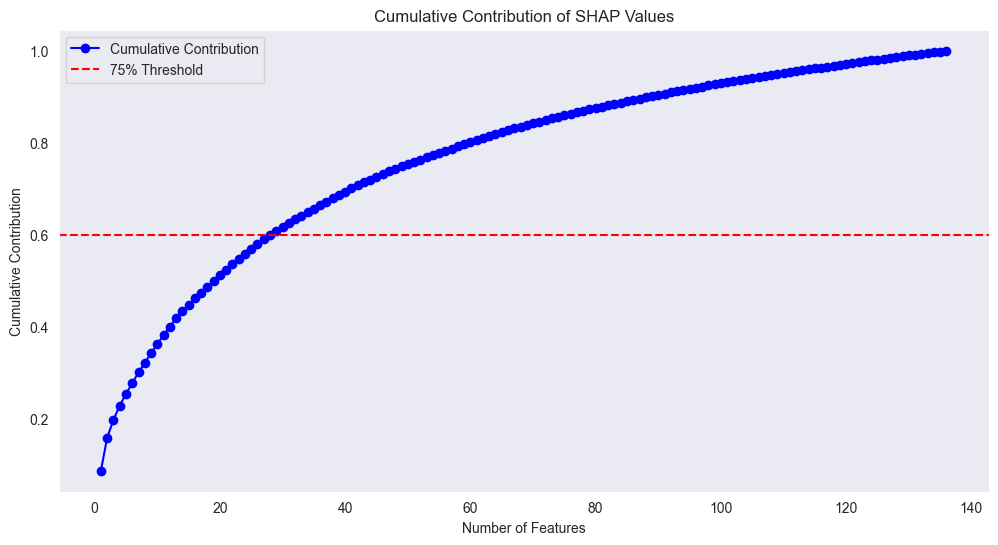

In [18]:
plt.figure(figsize=(12, 6))
plt.plot(
    range(1, len(shap_importance_df_reduced) + 1),
    shap_importance_df_reduced["Cumulative Contribution"],
    marker="o",
    linestyle="-",
    color="blue",
    label="Cumulative Contribution"
)
plt.axhline(y=0.6, color="red", linestyle="--", label="75% Threshold")
plt.title("Cumulative Contribution of SHAP Values")
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Contribution")
plt.legend()
plt.grid()
plt.show()


# Keep features contributing up to the threashhold of 60%

In [19]:
selected_features = shap_importance_df_reduced[
    shap_importance_df_reduced["Cumulative Contribution"] <= 0.45
]["Feature"]

# Final reduced dataset
X_train_reduced2 = X_train_reduced1[selected_features]
X_test_reduced2 = X_test_reduced1[selected_features]

# Get the feature names from the reduced dataset
selected_features_Shap = X_train_reduced2.columns

# Get the indexes of these features in the original dataset
selected_feature_indexes_Using_Shap= [X.columns.get_loc(feature) for feature in selected_features_Shap]

# Print the selected indexes
print("Indexes of selected features in the original dataset:", selected_feature_indexes_Using_Shap)


Indexes of selected features in the original dataset: [125, 132, 440, 425, 62, 417, 119, 133, 57, 134, 475, 381, 58, 341, 130]


# Save combined Features to CSV

In [20]:
combined_indices = set(indices_after_filter) | set(indices_afer_embeded) | set(selected_feature_indexes_Using_Shap)

combined_indices = sorted(list(combined_indices))  
X_train_selected = X.iloc[:, combined_indices]
X_test_selected = X_test.iloc[:, combined_indices]

train_filtered = pd.concat([X_train_selected, y.reset_index(drop=True)], axis=1)
test_filtered = pd.concat([X_test_selected, y_test.reset_index(drop=True)], axis=1)

print("Train Dataset (Features Selected) :")
train_filtered

Train Dataset (Features Selected) :


,DFA,ppq5Jitter,f1,mean_MFCC_1st_coef,mean_MFCC_2nd_coef,mean_MFCC_6th_coef,mean_1st_delta,std_4th_delta,std_7th_delta,std_delta_delta_log_energy,...,tqwt_TKEO_mean_dec_13,tqwt_TKEO_std_dec_11,tqwt_medianValue_dec_30,tqwt_meanValue_dec_21,tqwt_meanValue_dec_34,tqwt_skewnessValue_dec_1,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_36,target
0,-1.692289,-0.682321,1.226045,-1.148474,-1.374871,-0.126839,-0.279175,-1.299475,-1.098910,-0.868048,...,0.010409,-0.317907,0.063489,-0.782596,0.565713,0.121051,0.787236,-0.079631,-0.695013,0
1,-0.228688,-0.445175,1.216409,0.572678,-1.002322,-0.013564,-0.947813,0.008362,-0.748693,-0.223166,...,0.227613,0.706918,-0.097425,2.381178,-0.039609,-0.023402,1.563900,1.352261,-0.659537,0
2,1.304844,10.484072,-1.249384,-0.172259,2.000269,0.316125,-2.330649,-0.182683,-0.392163,0.830705,...,-0.389422,-0.524074,-0.036893,0.876499,0.227049,-0.025273,-0.515796,-0.677210,-0.565391,1
3,0.177523,-0.126740,-1.025798,1.008097,-0.275431,-1.060113,0.655496,0.381859,0.878237,0.548797,...,-0.436937,-0.063662,-1.408458,0.041643,-6.092687,-0.636959,-0.518804,-0.657437,-0.479013,0
4,-1.245788,-0.635371,2.178128,0.235094,-1.997954,1.045548,0.509020,-1.014131,-0.767219,-0.739011,...,1.596023,0.494967,0.031508,1.035749,-0.171632,0.092370,1.070559,-0.175428,-0.693671,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,-0.170650,0.600992,-0.377376,0.834720,-0.231152,1.116164,-0.592327,0.868965,1.412558,0.951241,...,-0.423140,-0.480596,0.051099,-0.258519,0.076150,0.003937,-0.533330,-0.675005,1.113291,1
842,-1.009457,-0.451893,0.703236,1.065511,-1.123105,-0.722392,0.359014,-0.243092,-1.352571,-0.651564,...,0.560260,0.173674,-0.048159,0.605159,0.449163,0.060966,-0.529581,1.425262,-0.712401,0
843,0.620354,-0.400525,-0.565368,0.647660,-0.568680,0.669414,-0.277153,-0.820107,-1.044903,-0.671330,...,1.677261,0.117951,-0.010256,1.174338,0.792906,0.027701,0.510710,-0.153490,-0.673837,0
844,-0.778424,-0.590573,1.721171,-1.681764,0.150755,1.045952,0.457794,-1.103052,-0.953883,-0.692959,...,0.564049,-0.119339,-0.166850,0.476321,-0.526984,-0.029663,1.159861,0.541811,-0.696314,0


# Save Combined Features data to csv File

In [21]:
train_filtered.to_csv("../../data/processed/train_filtered.csv", index=False)
test_filtered.to_csv("../../data/processed/test_filtered.csv", index=False)